# Load in the Data Using Generator

Each sample in the dataset has a unique ID. In the following code, when defining the generator, we first get the list of ID's from the RGB folder, then use the list of ID's to load the corresponding information of each sample. Associated with each sample is the following information (size and directory name for the training set are also listed):
    1. RGB image (512 * 512 * 3) (train/images/rgb)
    2. NIR image (512 * 512 * 1) (train/images/rgb)
    3. Boundary (512 * 512 * 1) (train/boundaries)
    4. Mask (512 * 512 * 1) (train/masks)
The task of this project is to use the information above to predict for each pixel, which of the six categories it belons to:
    1. Cloud shadow (512 * 512 * 1) (train/labels/cloud_shadow)
    2. Double plant (512 * 512 * 1) (train/labels/double_plant)
    3. Planter skip (512 * 512 * 1) (train/labels/planter_skip)
    4. Standing water (512 * 512 * 1) (train/labels/standing_water)
    5. Waterway (512 * 512 * 1) (train/labels/waterway)
    6. Weed cluster (512 * 512 * 1) (train/labels/weed_cluster)
If a pixel does not belong to any category above, it is considered to be
    0. Background

In [5]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import image as mpimg
from matplotlib import pyplot as plt

#keras imports
import keras
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.merge import concatenate, add
from keras.layers.convolutional import Conv2DTranspose
from keras.utils import np_utils
from keras.models import Model
from keras.callbacks import Callback


def id_check(path, ntail, ids):
    fignames = os.listdir(path)
    for fig_id in ids:
        if not fig_id + ntail in fignames:
            return False
    return True


def make_label(raw_labels):
    """
    This function creates a 7-channel label from the six labels (add a background channel).
    """
    stacked_labels = np.stack(raw_labels, axis=-1)
    last_label = np.sum(stacked_labels, axis=-1) + 1
    last_label[last_label > 1] = 0
    # Put the background as the last channel of the label
    full_labels =  np.concatenate([stacked_labels, last_label.reshape((512, 512, 1))], axis=-1)
    return full_labels / np.linalg.norm(full_labels, axis=-1).reshape((512, 512, 1))
    


def img_gen(dataset='train'):
    rgb_path = os.path.join(dataset, 'images', 'rgb')
    nir_path = os.path.join(dataset, 'images', 'nir')
    bdry_path = os.path.join(dataset, 'boundaries')
    mask_path = os.path.join(dataset, 'masks')
    label_names = ['cloud_shadow', 'double_plant', 'planter_skip', 'standing_water', 'waterway', 'weed_cluster']
    label_paths = [os.path.join(dataset, 'labels', label_name) for label_name in label_names]
    
    rgb_fig_names = os.listdir(rgb_path)
    fig_ids = [fname[:-4] for fname in rgb_fig_names]
    for fig_id in fig_ids:
        rgb_img = mpimg.imread(os.path.join(rgb_path, fig_id + '.jpg'))
        nir_img = mpimg.imread(os.path.join(nir_path, fig_id + '.jpg')).reshape((512, 512, 1))
        bdry_img = mpimg.imread(os.path.join(bdry_path, fig_id + '.png'))
        mask_img = mpimg.imread(os.path.join(mask_path, fig_id + '.png'))
        label_imgs = [mpimg.imread(os.path.join(label_path, fig_id + '.png')) for label_path in label_paths]
        input_img = np.concatenate([rgb_img, nir_img], axis=2) / 255. # Concatenate the RGB and NIR
        label = make_label(label_imgs)
        yield fig_id, input_img, bdry_img, mask_img, label

In [14]:
# Counting the number of positives for each class
counts = [0]*6
label_names = ['cloud_shadow', 'double_plant', 'planter_skip', 'standing_water', 'waterway', 'weed_cluster']
cnt =0
for fig_id, input_img, bdry_img, mask_img, label in img_gen():
    cnt += 1

    for i in range(len(label_names)):
        counts[i]+= np.sum(label[:,:,i])
        # print(label[:,:,i], np.sum(label[:,:,i]))
    if cnt == 5000:
        break

for i in range(len(label_names)):
    print(label_names[i],counts[i])

KeyboardInterrupt: 

In [ ]:
plt.bar(range(len(label_names)), counts)
plt.xticks(range(len(label_names)), label_names, rotation = 45)
plt.title("Number of pixels with a certain \n class in the first 5000 images")
plt.show()

# Visualize a Training Sample

Next we see a visualization of the training sample. The first four images are RGB image, NIR image, boundary and mask. Multiplying the boundary with the mask gives you the "final mask", in which the pixels that you need to classify are marked white (with value 1), and the pixels you don't need to classify are marked black (with value 0). The next three images shows the RGB and the NIR image after you apply the boundary and the mask, and the "final mask".

Continuing to the next six images, these shows the labels corresponding to cloud shadow, double plant, planter skip, standing water, water way, and weed cluster. Pixels marked white (with value 1) in the image belongs to the category of the corresponding image. For instance, in the last label image (corresponding to the water way), the pixels that appears white belongs to the category of waterway.

The last image shows the background. A pixel belongs to the category of background if it does not belong to any of the six categories above.

You can change the "sample_idx" to see more examples.

# Handling the Labels

Pay attention to the "make_label" function in the first code block. After reading in the label of a sample, you will get six arrays each with size (512 * 512). However, it would be more handy to deal with an array of (512 * 512 * 7). This 7-channel array gives a one-hot encoding of each pixel's category.

Figure ID: YNMRGGVQ3_5296-614-5808-1126


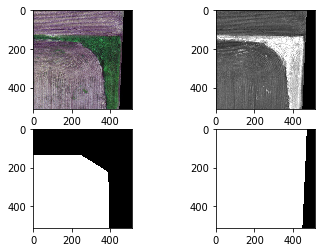

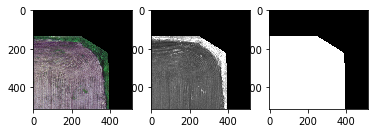

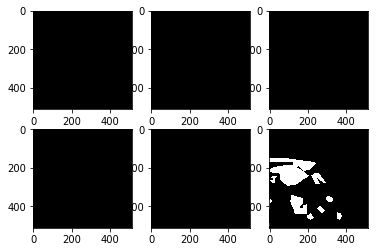

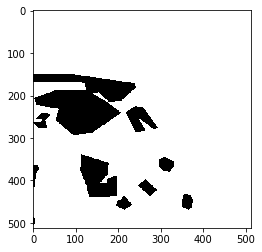

In [7]:
sample_idx = 25
cnt = 0
for fig_id, input_img, bdry_img, mask_img, label in img_gen():
    cnt += 1
    if cnt == sample_idx:
        print('Figure ID: %s' % fig_id)
        plt.figure(0)
        ax1 = plt.subplot(221)
        ax1.imshow(input_img[:, :, :3])
        ax2 = plt.subplot(222)
        ax2.imshow(input_img[:, :, 3], cmap='gray')
        ax3 = plt.subplot(223)
        ax3.imshow(bdry_img, cmap='gray', vmin=0, vmax=1)
        ax4 = plt.subplot(224)
        ax4.imshow(mask_img, cmap='gray', vmin=0, vmax=1)
        
        plt.figure(1)
        final_mask = np.multiply(bdry_img, mask_img) # The final mask is the intersection of the boundary and the mask.
        masked_img = np.multiply(input_img, final_mask.reshape((512, 512, 1)))
        ax1 = plt.subplot(131)
        ax1.imshow(masked_img[:, :, :3])
        ax2 = plt.subplot(132)
        ax2.imshow(masked_img[:, :, 3], cmap='gray')
        ax3 = plt.subplot(133)
        ax3.imshow(final_mask, cmap='gray')
        
        plt.figure(2)
        for i in range(6):
            ax = plt.subplot(231 + i)
            ax.imshow(label[:, :, i], cmap='gray', vmin=0, vmax=1)
        
        plt.figure(3)
        plt.imshow(label[:, :, 6], cmap='gray', vmin=0, vmax=1)
        break

# Handling the Boundary and the Mask

In [ ]:
# Counting the number of positives for each class
for fig_id, input_img, bdry_img, mask_img, label in img_gen():
    for i in range(len(label))


Many of you are confused about how to handle the boundary and the mask. If you read the instruction from git github repo (https://github.com/SHI-Labs/Agriculture-Vision), then you would see that the mask and the boundary pretty much has the same function: pixels that appear to be black in either mask and or boundary are the pixels that you don't need to classify for! Therefore, what we would like to do is to multiply the mask with the boundary to form the "final mask", as we did in the code above. This "final mask" contains all information from the mask and the boundary.

How to use the "final mask"? One option could be to multiply it with the RGB and NIR image. This "blacks out" all pixels that you don't need to consider in you classification. Although this is a convenient approach, it may gives you trouble when you start using more complicated methods like CNN, as the "blacked out" pixels are just zeros, and they still plays a roll in the whole network (affects the forward and backward process). Therefore, it is important to find a way to completely eliminate the influence of these pixels. This is a very important an interesting part of this project.

# Create and Train UNET

In [2]:
#start with UNET implementation

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
               kernel_initializer = 'he_normal', padding = 'same', activation = 'relu')(input_tensor)
   
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', activation = 'relu')(x)
    
    return x
def createUnet(input_img, n_filters = 16, dropout = 0.1):
    #Down the Unet
    conv1 = conv2d_block(input_img, n_filters)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)
    
    conv2 = conv2d_block(pool1, n_filters*2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2)
    
    conv3 = conv2d_block(pool2, n_filters*4)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)
    
    conv4 = conv2d_block(pool3, n_filters*8)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout)(pool4)
    #bottom of the unet
    conv5 = conv2d_block(pool4, n_filters*16)
    
    #up the U
    uconv4 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(conv5)
    uconv4 = concatenate([uconv4, conv4])
    uconv4 = conv2d_block(uconv4, n_filters*8)
    
    uconv3 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(uconv4)
    uconv3 = concatenate([uconv3, conv3])
    uconv3 = conv2d_block(uconv3, n_filters*4)
    
    uconv2 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(uconv3)
    uconv2 = concatenate([uconv2, conv2])
    uconv2 = conv2d_block(uconv2, n_filters*2)
    
    uconv1 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(uconv2)
    uconv1 = concatenate([uconv1, conv1])
    uconv1= conv2d_block(uconv1, n_filters*1)
    
    output = Conv2D(filters = 7, kernel_size = (1,1), activation = "softmax", padding = 'same')(uconv1)
    model = Model(inputs=[input_img], outputs=[output])
    return model

    

In [3]:
def masked_img_gen(dataset='train'):
    fig_id, input_img, bdry_img, mask_img, label = next(img_gen(dataset))
    final_mask = np.multiply(bdry_img, mask_img).reshape(512, 512, 1) # Form the final mask
    masked_img = np.multiply(final_mask, input_img)
#     masked_img = tf.expand_dims(masked_img, axis =-1)
    masked_img = masked_img.reshape(-1, 512, 512, 4)
    label = label.reshape(-1, 512, 512, 7)
    yield masked_img, label
# sample = next(img_gen())
# print(sample[1].shape, sample[4].shape)
# print(next(masked_img_gen())[1].shape)


In [8]:
keras.backend.clear_session()
input_img = Input((512, 512, 4), name='img')
model = createUnet(input_img)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics = ['accuracy'])

model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 592         img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
class AccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.accs = []
        self.acc_avg = []

    def on_batch_end(self, batch, logs={}):
        self.accs.append(round(1e2*float(logs.get('acc')),4))
        self.acc_avg.append(round(np.mean(self.accs,dtype=np.float64),4))

    def on_epoch_end(self, batch, logs={}):
        self.accs = []

In [10]:
# Train the model, doing validation at the end of each epoch.
epochs = 1
model.fit(masked_img_gen('train'), epochs=epochs, validation_data=masked_img_gen('val'))

1/1 [==============================] - 8s 8s/step - loss: 1.8543 - accuracy: 0.6151 - val_loss: 15.5676 - val_accuracy: 0.6895


In [10]:
class DummyClassifier:
    
    def __init__(self):
        # Randomly generate some parameters.
        self.param = np.random.normal(size=(4, 7))
        
    def softmax(self, logits):
        batch_size = logits.shape[0]
        exp_val = np.exp(logits)
        normalizer = np.sum(exp_val, axis=-1).reshape((batch_size, 512, 512, 1))
        return exp_val / normalizer
    
    def predict(self, X):
        result = self.softmax(X @ self.param)
        return result
    
def MSE(y_true, y_pred):
    """
    For simplicity, we use the MSE loss, but it is better to use cross entropy loss with softmax.
    """
    return np.sum(np.power(y_pred - y_true, 2)) / y_true.shape[0]


cnt = 0
X_list = []
y_list = []
fig_ids = []
for fig_id, input_img, bdry_img, mask_img, label in img_gen():
    cnt += 1
    fig_ids.append(fig_id)
    y_list.append(label) # 
    final_mask = np.multiply(bdry_img, mask_img).reshape(512, 512, 1) # Form the final mask
    masked_img = np.multiply(final_mask, input_img) # Multiply with the RGB and NIR image
    X_list.append(masked_img)
    if cnt == 10:
        break
X_batch = np.stack(X_list, axis=0)
y_batch = np.stack(y_list, axis=0)
# Check the shape of X and y.
print(X_batch.shape, y_batch.shape)

# Initialize a classifierModel was constructed with shape (None, 512, 512, 4) for input KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 4), dtype=tf.float32, name='img'), name='img', description="created by layer 'img'"), but it was called on an input with incompatible shape (None, None, None).
classifier = DummyClassifier()
# Predict on X_batch
y_pred = classifier.predict(X_batch)
print(y_pred.shape) # Expected to be of the same shape as y_batch
# Compute the error
error = MSE(y_batch, y_pred)
print(error) # Expected to be very large since we are doing random classification.

(10, 512, 512, 4) (10, 512, 512, 7)
(10, 512, 512, 7)
270103.9834263688


# Example: Dummy Classifier

In the following example, we take 10 samples from the training set, use a dummy classifier to train it, and compute loss with respect to the labels. The dummy classifier does nothing else but generate random classification, but this gives you a sense of what should be considered as input of the model, and what should be considered as output.

In our example we will just use the very basic method to handle the mask and the boundary: we multiply the image with the "final mask". Keep in mind that you are expected to explore more method of handling the mask and the boundary.

# Save the Predictions

The next step is to save the 10 predictions under the name of their ID. Before saving the result, we first need to convert the 7-channel prediction (one-hot) into the 1-channel representation. Note that when generate the background label we appended as the 7th channel. Therefore, when converting to 1-channel representation, it would be handy to first bring that channel to the first channel, so that the channel index of each category matches the coresponding value indicator (0-6) of each category. The 10 predictions are saved under a directory named "pred_example".

In [44]:
from PIL import Image

if not os.path.isdir('pred_example'):
    os.mkdir('pred_example')

for i in range(10):
    pred_result = y_pred[i] # take the ith predictio
    # Since we appended the background to the last channel, we need to bring it to the front when saving predictions
    processed_result = np.concatenate([pred_result[:, :, -1].reshape((512, 512, 1)), pred_result[:, :, :-1]], axis=-1)
    print(processed_result.shape) # Should be (512, 512, 7)
    # Convert the 7-channel result to 1-channel result and cast to uint8
    final_pred = np.argmax(processed_result, axis=-1).astype(np.uint8)
    print(final_pred.shape) # Should be (512, 512)
    # Save the prediction
    filename = os.path.join('pred_example', fig_ids[i] + '.png')
    Image.fromarray(final_pred).save(filename)

(512, 512, 7)
(512, 512)
(512, 512, 7)
(512, 512)
(512, 512, 7)
(512, 512)
(512, 512, 7)
(512, 512)
(512, 512, 7)
(512, 512)
(512, 512, 7)
(512, 512)
(512, 512, 7)
(512, 512)
(512, 512, 7)
(512, 512)
(512, 512, 7)
(512, 512)
(512, 512, 7)
(512, 512)


# Zip the Result

Finally, zip the files in the "pred_example" folder using:\
   ```zip submission.zip *.png```\
The result can be submitted to the server for evaluation (here we are predicting only 10 samples for the training set. For the server to process your submission, you need to predict all samples in the test set). 